<a href="https://colab.research.google.com/github/evpozdniakov/ds_projects/blob/master/hw13/book_shop_sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('https://github.com/evpozdniakov/ds_projects/raw/master/hw13/data/tovar_moving.csv', index_col='date', parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1439 entries, 2009-12-25 to 2013-12-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   qty     1439 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB


In [3]:
df.head()

,qty
date,
2009-12-25,72314.0
2009-12-26,66586.0
2009-12-27,125199.0
2009-12-28,91544.0
2009-12-29,76995.0


1. Отложите в test последнее значение временного ряда.

In [4]:
# Делим выборку на тренировочную и тестовую

train_data = df.iloc[:-1]
test_data = df.iloc[-1:]

2. Проанализируйте временной ряд на наличие тренда и сезонности.

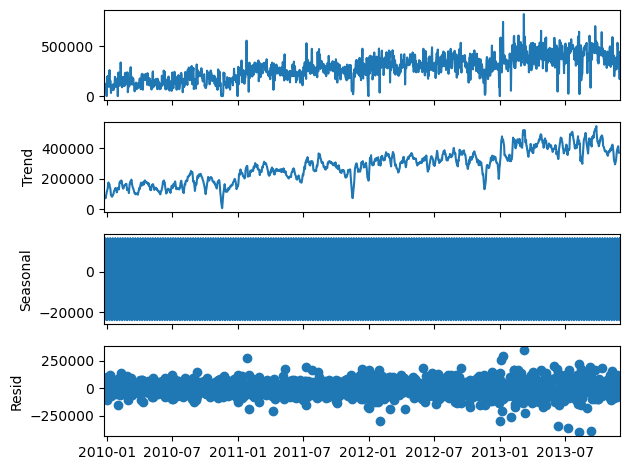

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

#производим декомпозицию временного ряда 
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show()

Тренд явно имеется. С сезонностью что-то непонятное.

3. Постройте прогноз на одно последнее значение с помощью экспоненциального сглаживания (alpha=0.7). Сравните результат с фактическим значением, которое вы отложили вначале.

In [34]:
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn import metrics

ses = SimpleExpSmoothing(train_data)

alpha = 0.7

model = ses.fit(smoothing_level=alpha, optimized=False)

forecast = model.forecast(1)

def compare_test_and_forecast(test_data, forecast):
    print('Значение из тестовой выборки:')
    print(test_data)

    print('\nПрогноз:')
    print(forecast)

    print('\nСравние предсказания с тестовыми данными:')
    print(f'MAPE: {metrics.mean_absolute_percentage_error(test_data, forecast)}')

compare_test_and_forecast(test_data, forecast)

Значение из тестовой выборки:
                 qty
date                
2013-12-02  423846.0

Прогноз:
2013-12-02    225015.522647
Freq: D, dtype: float64

Сравние предсказания с тестовыми данными:
MAPE: 0.46911018943878297


/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


4. Проверьте ряд на стационарность, определите порядок интегрирования.

In [26]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def check_stationary_time_series(df):
    result = adfuller(df.values)

    for key, value in result[4].items():
        if result[0] < value:
            print(f'Ряд скорее всего стационарен (вероятность ошибки {key})')
        else:
            print(f'Ряд скорее всего нестационарен (вероятность ошибки {key})')

check_stationary_time_series(df)

Ряд скорее всего нестационарен (вероятность ошибки 1%)
Ряд скорее всего нестационарен (вероятность ошибки 5%)
Ряд скорее всего нестационарен (вероятность ошибки 10%)


In [27]:
# Наш исходный ВР оказался нестационарным

# Получаем дифференцированный ряд 1 порядка
df_diff_1 = df.diff().dropna()

# Проверяем его на стационарность
check_stationary_time_series(df_diff_1)

Ряд скорее всего стационарен (вероятность ошибки 1%)
Ряд скорее всего стационарен (вероятность ошибки 5%)
Ряд скорее всего стационарен (вероятность ошибки 10%)


5. Определите порядок модели AR по графику частичной автокорреляции.

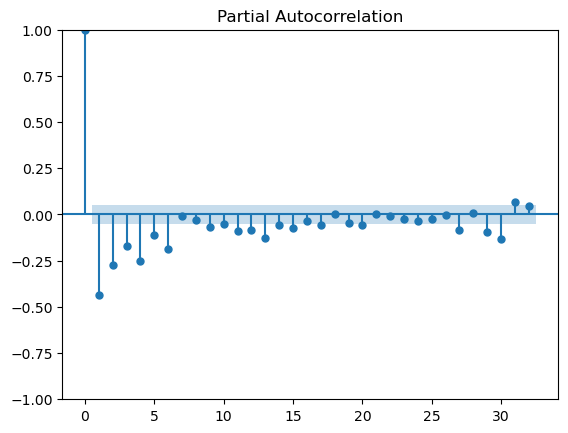

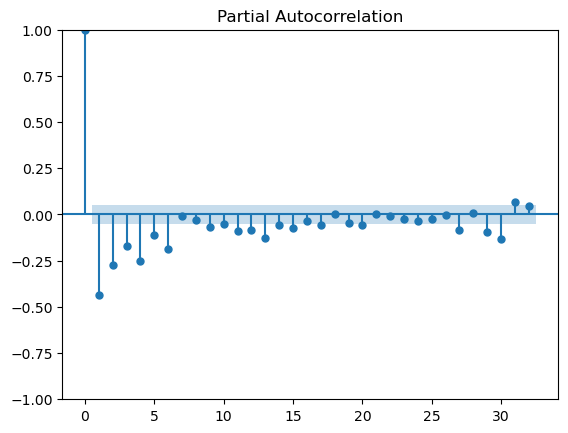

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf

# Строим график частичной автокорреляции на полученном стационарном ряду df_diff_1
plot_pacf(df_diff_1)

Из графика видим, что кол-во предыдущих значений с высокими коэфициентами равно `6`. Таков будет и порядок модели атворегрессии.

6. Постройте модель AR и предскажите последнее значение ряда.

In [36]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

# строим нашу модель на исходных данных, а не на дифференцированных
ar_model = AutoReg(train_data, lags=6).fit()

start = len(train_data) + 1
end = start
forecast = ar_model.predict(start=start, end=end, dynamic=False)

print(forecast)

2013-12-03    305957.697024
Freq: D, dtype: float64


/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


7. Сравните полученные результаты.

In [37]:
compare_test_and_forecast(test_data, forecast)

Значение из тестовой выборки:
                 qty
date                
2013-12-02  423846.0

Прогноз:
2013-12-03    305957.697024
Freq: D, dtype: float64

Сравние предсказания с тестовыми данными:
MAPE: 0.2781394727699949


Видим, что предсказание с помощью авторегрессии `MAPE=0.28` оказалось более точным, по сравнению с экспоненциальным сглаживанием `MAPE=0.47`.